In [2]:
# Libraries

import pandas as pd
import numpy as np
import country_converter as coco
import calendar

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# Silencing the warnings
import warnings
warnings.filterwarnings('ignore')

# Resetting the default matplotlib style (the style was changed because of the yellowbrick lib import)
from yellowbrick.style import reset_defaults, reset_orig 
reset_defaults()
reset_orig()

In [3]:
df = pd.read_csv("cleaned_sales_data.csv")
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalMoney,Month,Year
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,12,2019
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,12,2019
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,12,2019
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,12,2019
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,12,2019


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  int64  
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536350 non-null  float64
 7   Country        536350 non-null  object 
 8   TotalMoney     536350 non-null  float64
 9   Month          536350 non-null  int64  
 10  Year           536350 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 45.0+ MB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('category')

In [6]:
df['Month'] = df['Date'].dt.month_name().astype('category')
df['Year'] = df['Date'].dt.year.astype('category')

In [14]:
df.rename(columns={'TotalMoney': 'Revenue'}, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  536350 non-null  int64         
 1   Date           536350 non-null  datetime64[ns]
 2   ProductNo      536350 non-null  object        
 3   ProductName    536350 non-null  object        
 4   Price          536350 non-null  float64       
 5   Quantity       536350 non-null  int64         
 6   CustomerNo     536350 non-null  float64       
 7   Country        536350 non-null  object        
 8   Revenue        536350 non-null  float64       
 9   Month          536350 non-null  category      
 10  Year           536350 non-null  category      
 11  DayOfWeek      536350 non-null  category      
 12  CountryISO3    535845 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 42.5+ MB


In [8]:
# Set logical ordering for months
df['Month'] = df['Month'].cat.reorder_categories([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
], ordered=True)
# Check data types
print(df[['Month', 'Year']].dtypes)

# Show value counts
print(df['Month'].value_counts().sort_index())
print(df['Year'].value_counts().sort_index())

Month    category
Year     category
dtype: object
Month
January      34808
February     27409
March        36259
April        29466
May          36578
June         36440
July         39041
August       34935
September    49767
October      60145
November     84047
December     67455
Name: count, dtype: int64
Year
2018     42094
2019    494256
Name: count, dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  536350 non-null  int64         
 1   Date           536350 non-null  datetime64[ns]
 2   ProductNo      536350 non-null  object        
 3   ProductName    536350 non-null  object        
 4   Price          536350 non-null  float64       
 5   Quantity       536350 non-null  int64         
 6   CustomerNo     536350 non-null  float64       
 7   Country        536350 non-null  object        
 8   TotalMoney     536350 non-null  float64       
 9   Month          536350 non-null  category      
 10  Year           536350 non-null  category      
 11  DayOfWeek      536350 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 38.4+ MB


In [ ]:
# Getting the unique values from country
countries = df['Country'].unique()

# Converting unique values from country to ISO3
iso3_countries = [coco.convert(country, to = 'ISO3') for country in countries]

# Treating several non-standard country names
res = dict(zip(countries, iso3_countries))
for i in res.keys():
    if i == 'EIRE':
        res[i] = 'IRL'
    elif i == 'Channel Islands':
        res[i] = 'GB-CHA'
    elif i == 'RSA':
        res[i] = 'ZAF'
    elif i in ('Unspecified', 'European Community'): # European community contains many countries! So we'll assume this'll be missing
        res[i] = np.nan

# Mapping the ISO3 results to DataFrame
df['CountryISO3'] = df['Country'].map(res)


EIRE not found in regex
Channel Islands not found in regex
RSA not found in ISO3
Unspecified not found in regex
European Community not found in regex


In [13]:
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalMoney,Month,Year,DayOfWeek,CountryISO3
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,December,2019,0,GBR
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,December,2019,0,GBR
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,December,2019,0,GBR
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,December,2019,0,GBR
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,December,2019,0,GBR


## RFM Segmentation

**RFM segments customer based on:** 

- Recency (R): How recently a customer made a purchase.

- Frequency (F): How often they purchase.

- Monetary (M): How much they spend.

**Business Applications:**

✔ High-Value Customers: Retain with loyalty programs.

✔ At-Risk Customers: Win back with discounts.

✔ New Customers: Engage with onboarding campaigns.

### RFM Preprocessing

In [17]:
# Getting the max Date, nunique of TransactionNo, and sum of Revenue per customer 
rfm_df = df.groupby('CustomerNo', as_index = False)[['Revenue', 'TransactionNo', 'Date']]\
                   .agg({'Date' : 'max',
                         'TransactionNo' : 'nunique',
                         'Revenue' : 'sum',})

# Renaming the columns
rfm_df.columns = ['CustomerNo', 'Recency', 'Frequency', 'Monetary']

# Converting the Recency column that contains max date to a datetime
rfm_df['Recency'] = pd.to_datetime(rfm_df['Recency'])

# Initializing 'date' variable that contains the analysis date
date = pd.to_datetime('2019-12-10')

# Subtracting max date from analysis date
rfm_df['Recency'] = date - rfm_df['Recency']

# Getting the days
rfm_df['Recency'] = rfm_df['Recency'].dt.days

# Checking the result
rfm_df

,CustomerNo,Recency,Frequency,Monetary
0,11500.0,2,1,-3342.60
1,11501.0,32,1,-44.25
2,11502.0,37,1,-25.37
3,11503.0,43,1,-14.50
4,11504.0,67,1,-21.47
...,...,...,...,...
4769,18280.0,278,1,623.26
4770,18281.0,181,1,576.58
4771,18282.0,8,3,992.11
4772,18283.0,4,16,12114.61


In [18]:
# Check transactions for customers with negative revenue
df[df['CustomerNo'].isin(rfm_df[rfm_df['Monetary'] < 0]['CustomerNo'])].sort_values('Revenue')

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Revenue,Month,Year,DayOfWeek,CountryISO3
242407,563015,2019-08-11,46000S,Polyester Filler Pad 40x40cm,10.25,220,11506.0,United Kingdom,-2255.00,August,2019,6,GBR
127022,572410,2019-10-24,22699,Roses Regency Teacup And Saucer,12.86,168,16742.0,United Kingdom,-2160.48,October,2019,3,GBR
285495,559296,2019-07-07,22616,Pack Of 12 London Tissues,10.25,204,11512.0,United Kingdom,-2091.00,July,2019,6,GBR
285494,559296,2019-07-07,23001,Travel Card Wallet Dotcomgiftshop,10.25,200,11512.0,United Kingdom,-2050.00,July,2019,6,GBR
6512,581406,2019-12-08,46000S,Polyester Filler Pad 40x40cm,6.19,300,11500.0,United Kingdom,-1857.00,December,2019,6,GBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19967,580158,2019-12-02,79191C,Retro Plastic Elephant Tray,6.19,24,12558.0,USA,148.56,December,2019,0,USA
19968,580158,2019-12-02,23392,Spaceboy Rocket Lolly Makers,6.19,24,12558.0,USA,148.56,December,2019,0,USA
19969,580158,2019-12-02,84828,Jungle Popsicles Ice Lolly Moulds,6.19,24,12558.0,USA,148.56,December,2019,0,USA
19970,580158,2019-12-02,23158,Set Of 5 Lucky Cat Magnets,6.19,36,12558.0,USA,222.84,December,2019,0,USA


In [21]:
# Option 1: Exclude negative values for RFM
rfm_df = rfm_df[rfm_df['Monetary'] > 0]

# # Option 2: Treat as zero
# rfm_df['Monetary'] = rfm_df['Monetary'].clip(lower=0)

In [22]:
rfm_df

,CustomerNo,Recency,Frequency,Monetary
14,11514.0,166,1,82.00
36,12004.0,228,1,1509.60
37,12006.0,219,1,24.76
38,12008.0,277,1,5689.57
39,12013.0,360,1,69.96
...,...,...,...,...
4769,18280.0,278,1,623.26
4770,18281.0,181,1,576.58
4771,18282.0,8,3,992.11
4772,18283.0,4,16,12114.61


### RFM Data: Exploration

In [23]:
# Statistical summary of RFM data
rfm_df.describe(exclude = 'object').round(2)

,CustomerNo,Recency,Frequency,Monetary
count,4705.00,4705.00,4705.00,4705.00
mean,15245.36,95.31,4.91,12818.45
std,1740.65,101.29,8.83,50700.70
min,11514.00,1.00,1.00,5.97
25%,13743.00,18.00,1.00,1821.38
50%,15250.00,52.00,3.00,4772.31
75%,16745.00,155.00,5.00,11748.54
max,18287.00,374.00,241.00,2108959.95


There are some interesting insights to take note here:

1. **Outliers:** The Frequency and Monetary columns show extreme outliers, with values of 248 transactions and 2.1M GBP, respectively. The Recency variable also indicates a potential outlier of 374 days. These outliers require careful handling to ensure they don't negatively influence the clustering process.

2. **Data Dispersion:** Across all RFM variables, the standard deviation exceeds the mean, indicating a wider spread of data points around the average value, suggesting that the data is more dispersed and less concentrated.

3. **Right Skewness:** All RFM variables display right-skewed distributions, with means higher than medians. This skewness could be mitigated by addressing the outliers identified earlier.

Next, let's investigate the distribution of all the RFM variables using box plots.

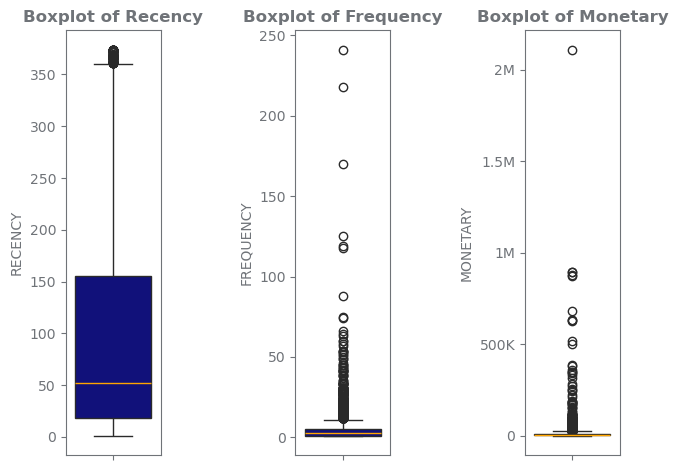

In [24]:
# Getting the RFM variables to plot
cols = rfm_df.columns[1:]

# Setting the figure and axes
fig, ax = plt.subplots(1, 3)

# Creating box plots
for col in range(len(cols)):

    # Creating the box plot
    sns.boxplot(y = cols[col], data = rfm_df, color = 'darkblue', 
                medianprops = {'color' : 'orange'}, ax = ax[col])
    
    # For the 'Monetary' box plot
    if cols[col] == 'Monetary':
        # Make the yticks more readable
        ax[col].set_yticks(range(0, 2500000, 500000), labels = ['0', '500K', '1M', '1.5M', '2M'])
        
    # Customizing the y label
    ax[col].set_ylabel(cols[col].upper(), color = '#6F7378')
    
    # Changing the tick color
    ax[col].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[col].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[col].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[col].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Adding the plot title
    ax[col].set_title(f'Boxplot of {cols[col]}', weight = 'bold', color = '#6F7378')    
        
# Showing the figure with a tight layout
plt.tight_layout(w_pad = 5)

There are some interesting observations here:

1. **Recency:** The Recency variable shows a few collective outliers but (thankfully) lacks extreme outliers, suggesting that the distribution of recency values is relatively well-behaved, with no extreme outliers significantly impacting the overall data pattern.

2. **Frequency and Monetary:** In contrast, the Frequency and Monetary variables show several global outliers that likely skew their distributions towards higher values (right skewness). These outliers deserve priority attention during the outlier handling process to ensure they don't negatively influence the analysis.

To further confirm our initial assessment of the distributional shapes of the RFM variables, let's dig deeper into their characteristics using histograms and skewness measures.



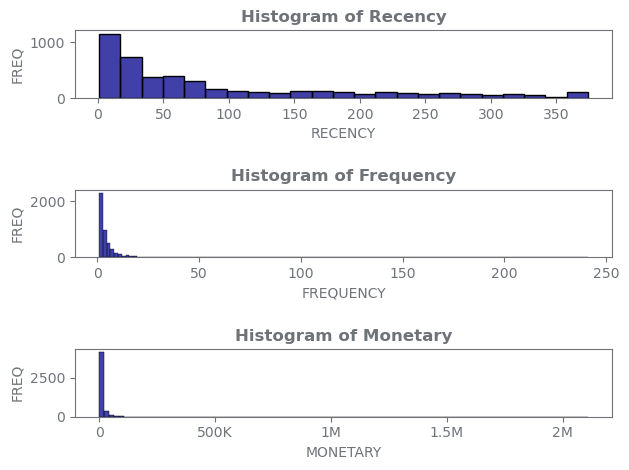

In [25]:
# Setting the figure and axes
fig, ax = plt.subplots(3, 1)

# Loop to create histograms across RFM variables
for col in range(len(cols)):
    
    # For the 'Frequency' histogram
    if cols[col] == 'Frequency':
        sns.histplot(x = cols[col], data = rfm_df, color = 'darkblue', bins = 130, ax = ax[col])
        
    # For the 'Monetary' histogram
    elif cols[col] == 'Monetary':
        sns.histplot(x = cols[col], data = rfm_df, color = 'darkblue', bins = 100, ax = ax[col])
        ax[col].set_xticks(range(0, 2500000, 500000), labels = ['0', '500K', '1M', '1.5M', '2M']) # Make the xticks more readable
        
    # For the 'Recency' histogram
    else:
        sns.histplot(x = cols[col], data = rfm_df, color = 'darkblue', ax = ax[col])
    
    # Customizing the y label
    ax[col].set_ylabel('FREQ', color = '#6F7378')
    ax[col].set_xlabel(cols[col].upper(), color = '#6F7378')
    
    # Changing the tick color
    ax[col].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[col].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[col].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[col].spines.values():
        spine.set_edgecolor('#6F7378')
    
    # Adding plot title
    ax[col].set_title(f'Histogram of {cols[col]}', weight = 'bold', color = '#6F7378')

# Showing the figure with a tight layout
plt.tight_layout(h_pad = 2)

In [27]:
# Skewness measure
print(f'Skewness measurements: \n{rfm_df.skew(numeric_only = True)}')


Skewness measurements: 
CustomerNo    -0.002800
Recency        1.174691
Frequency     11.655493
Monetary      22.224206
dtype: float64


This analysis confirms our initial assumptions that all of the RFM variables are right-skewed, with `Frequency` and `Monetary` exhibiting high degrees of skewness. Global outliers in these variables' values likely contribute to this extreme skewness.



#### Outlier Handling

In [28]:
# Getting and printing the total rows before outlier handling
original_data = len(rfm_df)
print(f'Rows before outlier handling (z-score): {original_data}')

# Creating the filter mask
filtered_entries = np.array([True] * len(rfm_df))

# IQR filtering
for i in cols:
    q1 = rfm_df[i].quantile(0.25)
    q3 = rfm_df[i].quantile(0.75)
    iqr = q3 - q1
    low_limit = q1 - (1.5 * iqr)
    high_limit = q3 + (1.5 * iqr)
    filtered_entries = ((rfm_df[i] >= low_limit) & (rfm_df[i] <= high_limit)) & filtered_entries

# Filtering the original data from outliers
rfm_df = rfm_df[filtered_entries]

# Getting and printing the total rows after outlier handling
new_data = len(rfm_df)
print(f'Rows before outlier handling (z-score): {len(rfm_df)}')
print(f'Data loss: {round((original_data - new_data) / new_data * 100, 2)}%')


Rows before outlier handling (z-score): 4705
Rows before outlier handling (z-score): 4059
Data loss: 15.92%


After the outlier removal using the IQR method, we experienced a data loss of approximately 13.6%. Let's now visualize the distribution of the processed data using box plots to assess the effectiveness of outlier handling.

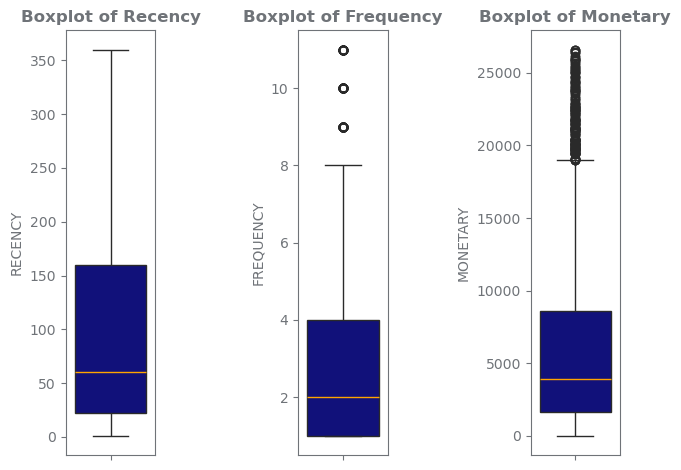

In [29]:
# Getting the RFM variables to plot
cols = rfm_df.columns[1:]

# Setting the figure and axes
fig, ax = plt.subplots(1, 3)

# Creating box plots
for col in range(len(cols)):
    
    # Creating the box plot
    sns.boxplot(y = cols[col], data = rfm_df, color = 'darkblue', 
                medianprops = {'color' : 'orange'}, ax = ax[col])
        
    # Customizing the y label
    ax[col].set_ylabel(cols[col].upper(), color = '#6F7378')
    
    # Changing the tick color
    ax[col].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[col].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[col].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[col].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Adding the plot title
    ax[col].set_title(f'Boxplot of {cols[col]}', weight = 'bold', color = '#6F7378')    
        
# Showing the figure with a tight layout
plt.tight_layout(w_pad = 5)

#### Scaling
Since clustering algorithms rely on distance calculations to assess the similarity between data points, data scaling is vital to ensure accurate and meaningful clustering results. Scaling normalizes the data, preventing variables with more extensive ranges, such as Monetary in this case, from excessively influencing the distance calculations. This technique ensures that all variables contribute equally to the clustering process, leading to a more balanced and representative outcome.

In [30]:
# Initializing the scaler object with Pandas DataFrame output
scaler = StandardScaler().set_output(transform = 'pandas')

# Fitting the RobustScaler to RFM data (Excluding the CustomerNo)
scaler.fit(rfm_df.iloc[:, 1:])

# Transform the RFM data to be robust-scaled (Excluding the CustomerNo)
rfm_df_std = scaler.transform(rfm_df.iloc[:, 1:])

# Checking the output
rfm_df_std

,Recency,Frequency,Monetary
14,0.695018,-0.884106,-1.029835
36,1.337344,-0.884106,-0.780591
37,1.244103,-0.884106,-1.039829
38,1.844989,-0.884106,-0.050813
39,2.704878,-0.884106,-1.031937
...,...,...,...
4768,-0.258112,-0.884106,-0.894944
4769,1.855349,-0.884106,-0.935337
4770,0.850419,-0.884106,-0.943487
4771,-0.941879,-0.045455,-0.870940


## RFM : Dimensionality Reduction (PCA)
We'll apply PCA here to enhance k-means performance by reducing redundancy and focusing on informative variables. This method minimizes the impact of multicollinearity, especially in RFM variables known for high multicollinearity. PCA also facilitates cluster visualization with 2D scatter plots instead of 3D, simplifying cluster understanding.



In [31]:
# Initializing the PCA object with 2 components
pca = PCA(n_components = 2)

# Fitting the PCA to the scaled rfm dataset
pca.fit(rfm_df_std)

# Transforming the scaled rfm dataset to PCA 
pca_df = pd.DataFrame(pca.transform(rfm_df_std), columns = ['pc1', 'pc2'])

# Ensuring that the index is the same with the original rfm dataset
pca_df.set_index(rfm_df.index, inplace = True)

# Showing the output
pca_df

,pc1,pc2
14,-1.517865,-0.077975
36,-1.682529,0.587678
37,-1.792836,0.389049
38,-1.492090,1.357402
39,-2.503619,1.647273
...,...,...
4768,-0.969831,-0.834904
4769,-2.029371,0.961813
4770,-1.542030,0.094982
4771,-0.091351,-1.217713


### RFM Clustering with K-Means

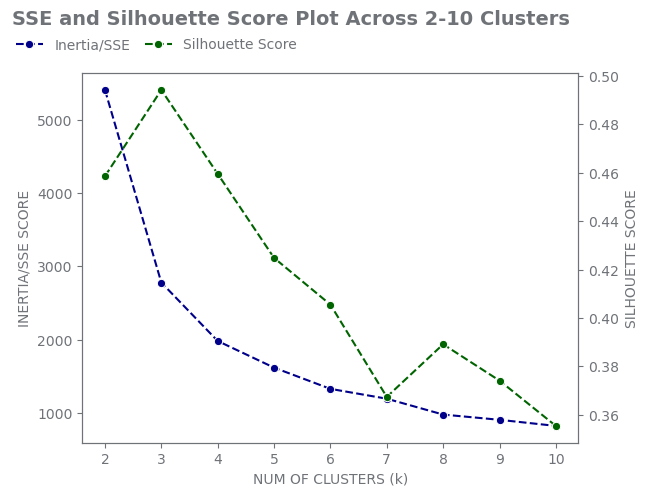

In [32]:
# Empty variables to be filled with sse (inertia) and silhouette scores
sse = []
silhouette = []

# Getting the sse and silhouette scores for k = 2 to k = 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 10).fit(pca_df)
    sse.append(kmeans.inertia_)
    cluster_label = kmeans.labels_
    silhouette.append(silhouette_score(pca_df, cluster_label))
    
# Plot of sse (inertia) and silhouette metrics
fig, ax = plt.subplots()

# Creating the lineplot for SSE Scores
sns.lineplot(x = range(2, 11), y = sse, marker = 'o', linestyle = '--', color = 'darkblue',
             label = 'Inertia/SSE', ax = ax)

# Adding secondary y axis for the Silhouette Score
ax2 = ax.twinx()

# Creating the lineplot for Silhouette Score
sns.lineplot(x = range(2, 11), y = silhouette, marker = 'o', linestyle = '--', color = 'darkgreen',
             label = 'Silhouette Score', ax = ax2)

# Adding x and y labels
ax.set_xlabel('NUM OF CLUSTERS (k)', color = '#6F7378')
ax.set_ylabel('INERTIA/SSE SCORE', color = '#6F7378')
ax2.set_ylabel('SILHOUETTE SCORE', color = '#6F7378')

# Adding legends
ax.legend(loc = 2, frameon = False, bbox_to_anchor = [-0.16, 1.13], labelcolor = '#6F7378')
ax2.legend(loc = 2, frameon = False, bbox_to_anchor = [0.1, 1.13], labelcolor = '#6F7378')

# Adding title
ax2.set_title('SSE and Silhouette Score Plot Across 2-10 Clusters', size = 14, pad = 35, 
              x = 0.42, weight = 'bold', color = '#6F7378')

# Changing the tick color
ax.tick_params(color = '#6F7378') 
ax2.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 
plt.setp(ax2.get_xticklabels(), color = '#6F7378') 
plt.setp(ax2.get_yticklabels(), color = '#6F7378') 

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')
for spine in ax2.spines.values():
    spine.set_edgecolor('#6F7378')

# Showing the plot
plt.show()

We can see that the optimal value for k is 3, which has the highest silhouette score and is located in the 'elbow' part of the SSE plot. We can further check with the silhouette plot.

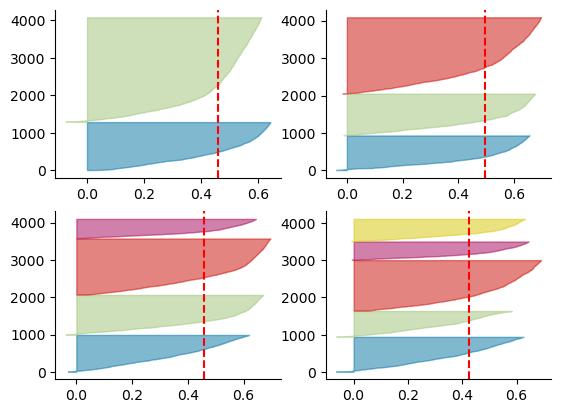

In [33]:
# Setting the figure and axes
fig, ax = plt.subplots(2, 2)

# Loop to create silhouette plots for each benchmarked 'k' values
for k in range(2, 6):
    km = KMeans(n_clusters = k, random_state = 10)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(pca_df)
    
# Removing the top and right spines
sns.despine(right = True)

# Showing the figure with a tight layout
plt.show()

All these k values show imbalanced cluster proportions, but k = 3 appears less imbalanced than the others. Moreover, k = 3 shows the least negative silhouette scores across each cluster.

Let's apply k equals 3 in the clustering process and get the cluster labels.



In [34]:
# K-means clustering with k = 3
km = KMeans(n_clusters = 3, random_state = 10)
km.fit(pca_df)

# Assigning the cluster label to the PCA data to be visualized
pca_df['Cluster'] = km.labels_

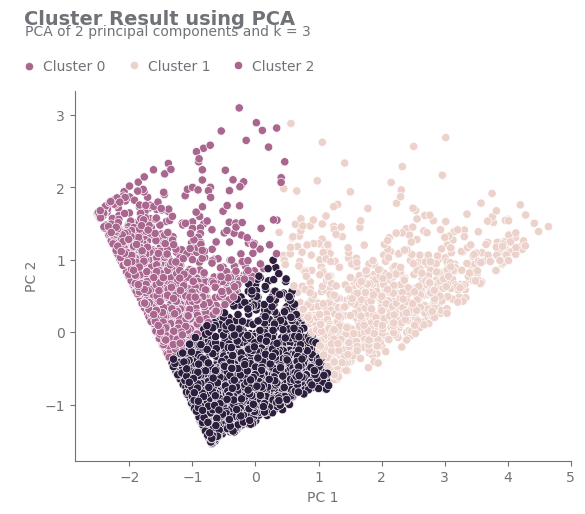

In [35]:
# Setting the figure and axes
fig, ax = plt.subplots()

# Using scatter plot to see the formed clusters
sns.scatterplot(x = 'pc1', y = 'pc2', hue = 'Cluster', data = pca_df, ax = ax)

# Removing the top and right spines
sns.despine(right = True)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('PC 1', color = '#6F7378')
ax.set_ylabel('PC 2', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Adding plot title and subtitle
ax.set_title('Cluster Result using PCA', size = 14, x = 0.17,
             pad = 48, color = '#6F7378', weight = 'bold')
ax.text(-3.65, 4.1, 'PCA of 2 principal components and k = 3', color = '#6F7378')

# Customizing the legends
ax.legend(loc = 2, ncol = 3, frameon = False, bbox_to_anchor = [-0.145, 1.12],
          labels = ['Cluster ' + str(i) for i in sorted(pca_df['Cluster'].unique())],
          handletextpad = 0, columnspacing = 1, labelcolor = '#6F7378')

# Showing the plot
plt.show()

From the visualization, we observe an acceptable separation between clusters, acknowledging a few instances where clusters appear to belong to either group. Despite this, the overall shape indicates that our clustering process has yielded decent clusters.

In [36]:
# Assigning produced clusters from the PCA data to the RFM data
rfm_df['Cluster'] = pca_df['Cluster']

# Grouping by cluster and aggregating the min, max, and median of RFM variables
rfm_df.groupby('Cluster').agg({'Recency' : ['mean', 'median', 'min', 'max'],
                               'Frequency' : ['mean', 'median', 'min', 'max'],
                               'Monetary' : ['mean', 'median', 'min', 'max']})

Recency                  Frequency                     Monetary  \
               mean median  min  max      mean median min max          mean   
Cluster                                                                       
0         41.268689   25.0    1  307  6.423619    6.0   1  11  14071.565688   
1        237.127371  235.0  132  360  1.593496    1.0   1   8   2856.588238   
2         49.729423   41.0    1  181  2.426811    2.0   1   8   4004.438763   

                                      
           median      min       max  
Cluster                               
0        13608.32  1657.98  26591.23  
1         1830.61    11.53  21255.40  
2         3307.37     5.97  16299.90

Based on the summary statistics of the identified clusters, we can tentatively label each cluster as follows:

- Cluster 0: **Occasional Customers** (Moderate R, F, and M)
- Cluster 1: **Loyal Customers** (Lowest R, Highest F and M)
- Cluster 2: **At-Risk Customers** (Highest R, Lowest F and M)


#### Cluster Distribution Visualization

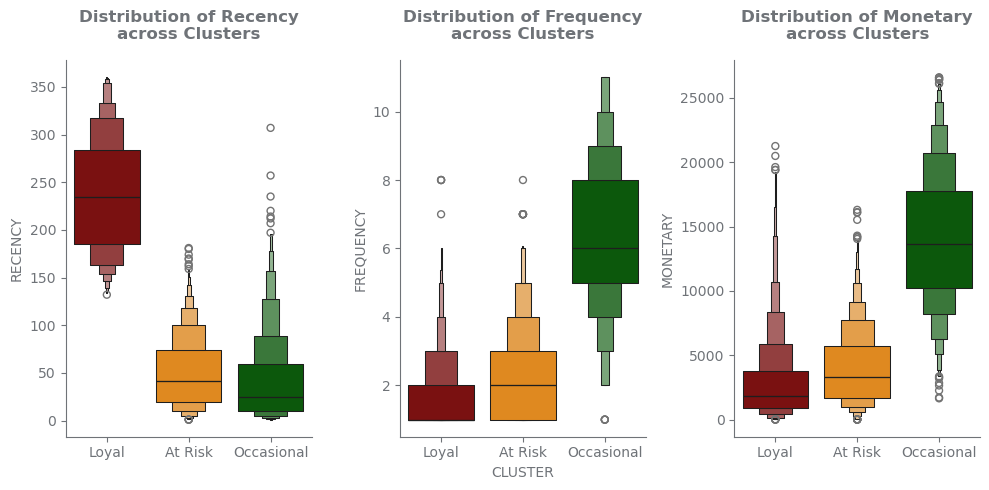

In [37]:
# Adding the ClusterName feature
cluster_map = {0 : 'Occasional', 
               1 : 'Loyal', 
               2 : 'At Risk'}

# Creating a variable 'ClusterName' that contains the name of each cluster
rfm_df['ClusterName'] = rfm_df['Cluster'].map(cluster_map)

# Getting the RFM variable names
cols = rfm_df.columns.tolist()[1:4] 

# Box plot of each cluster that compares the median of RFM variables
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
for i in range(len(cols)):
    sns.boxenplot(x = rfm_df['ClusterName'], y = rfm_df[cols[i]],
                  palette = ['darkred', 'darkorange', 'darkgreen'], ax = ax[i])
    
    # Adding plot titles
    ax[i].set_title(f'Distribution of {cols[i]}\nacross Clusters', pad = 15, color = '#6F7378', weight = 'bold')
    
    # Setting different x and y labels for each plot
    if i == 0:
        ax[i].set_ylabel('RECENCY', color = '#6F7378')
        ax[i].set_xlabel('')
    elif i == 1:
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378')
        ax[i].set_xlabel('CLUSTER', color = '#6F7378')
    else:
        ax[i].set_ylabel('MONETARY', color = '#6F7378')
        ax[i].set_xlabel('')
        
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
    
    # Removing the top and right spines
    sns.despine(right = True)
    
    # Removing the grids
    ax[i].grid(False)
    
plt.tight_layout()

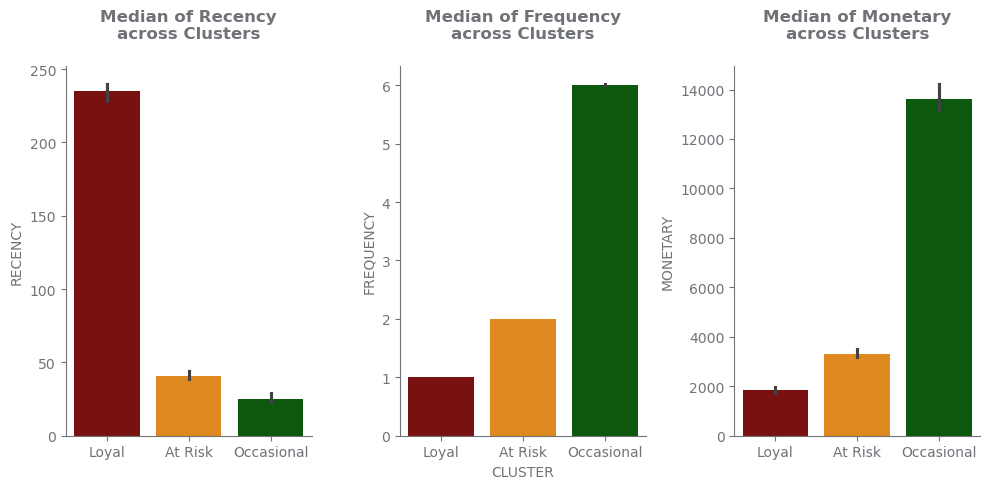

In [38]:
# Setting the figure and axes
fig, ax = plt.subplots(1, 3, figsize = (10, 5))

# Create bar plots for each RFM variables
for i in range(len(cols)):
    sns.barplot(x = rfm_df['ClusterName'], y = rfm_df[cols[i]], estimator = 'median',
                    palette = ['darkred', 'darkorange', 'darkgreen'], ax = ax[i])
    
    # Setting each plot's title
    ax[i].set_title(f'Median of {cols[i]}\nacross Clusters', pad = 20, color = '#6F7378', weight = 'bold')
    
    # Setting different x and y labels for each plot
    if i == 0:
        ax[i].set_ylabel('RECENCY', color = '#6F7378')
        ax[i].set_xlabel('')
    elif i == 1:
        ax[i].set_ylabel('FREQUENCY', color = '#6F7378')
        ax[i].set_xlabel('CLUSTER', color = '#6F7378')
    else:
        ax[i].set_ylabel('MONETARY', color = '#6F7378')
        ax[i].set_xlabel('')
        
    # Changing the tick color
    ax[i].tick_params(color = '#6F7378') 
    
    # Changing the x and y tick labels colors
    plt.setp(ax[i].get_xticklabels(), color = '#6F7378') 
    plt.setp(ax[i].get_yticklabels(), color = '#6F7378') 
    
    # Changing the spines colors
    for spine in ax[i].spines.values():
        spine.set_edgecolor('#6F7378')
        
    # Removing the top and right spines
    sns.despine(right = True)
    
    # Removing the grids
    ax[i].grid(False)
    
plt.tight_layout()

1. AT-RISK CUSTOMERS
- High recency:
    - At-risk customers have not made a recent purchase on the e-commerce platform, with a median of 239 days since their last order as of this analysis.
    - The spread of recency is wider than other clusters (IQR = 102 days), where customers typically have around 186-288 days since their last order as of this analysis.
    - This indicates a potential loss of interest in the e-commerce platform or a shift towards alternative options.
- Low frequency:
    - At-risk customers show infrequent purchasing behavior, with a median of only one purchase to date.
    - The frequency spread is tighter than other clusters (IQR = 1 transaction), where customers typically transact 1-2 times to date.
    - This suggests that they may not find the products or services they need on the platform or are drawn to competitors offering better products, deals, or discounts.
- Low monetary:
    - At-risk customers tend to make relatively small purchases when they engage with the platform, with a median spending of 1,846 GBP.
    - The monetary spread is tighter than other clusters (IQR = £2,935), where customers typically spend around £885-£3,820 to date in total.
    - This suggests that they may not perceive the products as high-value additions or have budget constraints limiting their spending.
2. OCCASIONAL CUSTOMERS
- Moderate recency:
    - Occasional customers have made purchases or interacted with the e-commerce platform moderately recently, with a median of 43 days since their last order as of this analysis.
    - The spread of recency is slightly wider than the Loyal Customers cluster but tighter than the At-Risk Customers cluster (IQR = 56 days), where customers typically have around 19-75 days since their last order as of this analysis.
    - This indicates they are still aware of the brand and may be open to future engagement.
    - However, they may not be as actively engaged as customers with higher recency scores, suggesting a need for targeted marketing efforts to maintain their interest.
- Moderate frequency:
    - Occasional customers show moderate purchasing behavior on e-commerce, with a median of 2 purchases to date.
    - The spread of frequency is slightly wider than the At-Risk Customers cluster but tighter than the Loyal Customers cluster (IQR = 2 transactions), where customers typically transact 1-3 times to date
    - This suggests that they are interested in the products offered but may not be habitual customers.
    - They may be responsive to price promotions, e-commerce innovations, or personalized marketing campaigns to increase purchase frequency.
- Moderate monetary:
    - Occasional customers spend moderate amounts when they place orders, with a median spending of 3,509 EUR to date.
    - The monetary spread is wider than the At Risk Customers cluster but tighter than the Loyal Customers cluster (IQR = £4,397), where customers typically spend around £1,764-£6,161 to date in total.
    - This suggests they see some value in e-commerce products but may view them as something other than their primary choice.
    - They may have other competing e-commerce options or are price-conscious, presenting an opportunity to give them exclusive offers or personalized recommendations.
3. LOYAL CUSTOMERS
- Low recency:
    - Loyal customers have made orders in the e-commerce very recently, with a median of 25 days since their last order as of this analysis.
    - The spread of recency is tighter than other clusters (IQR = 44 days), where customers typically have around 10-54 days since their last order as of this analysis.
    - This indicates that they are actively engaged with the platform and likely continue doing so.
    - They may be the people who are mostly responsive to new products, seasonal promotions, and new innovations in the e-commerce platform.
- High frequency
    - Loyal customers frequently made orders, with a median of 6 orders to date.
    - The frequency spread is wider than other clusters (IQR = 3 transactions), where customers typically transact 4-7 times to date.
    - This suggests that they are a habitual customer relying on e-commerce products.
    - Because of this, they may be susceptible to price changes or product availability.
- High monetary
    - Loyal customers spend large amounts when they order, with a median spending of 13,730 EUR to date.
    - The monetary spread is wider than other clusters (IQR = £7,447), where customers typically spend high.
    - This indicates that they see high value in the e-commerce products and are willing to pay high prices.
    - They may be more likely to consider upgrades and additional services.
Based on the clusters' characteristics above, the **Loyal Customers cluster** is our potential cluster to target.

#### Cluster Proportions in the Data

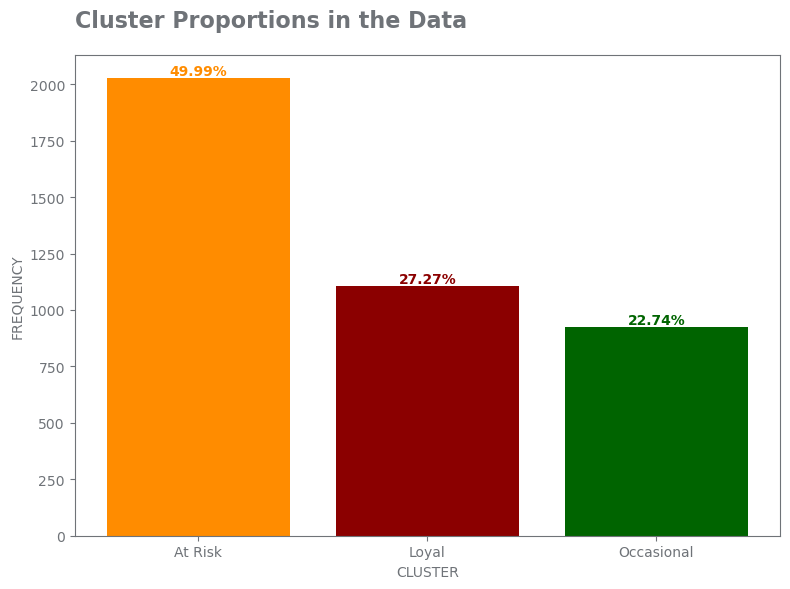

In [42]:
import matplotlib.pyplot as plt

# Calculate cluster proportions
cluster_size = rfm_df['ClusterName'].value_counts().reset_index()
cluster_size.columns = ['ClusterName', 'count']
cluster_size['prop'] = round((cluster_size['count'] / cluster_size['count'].sum()) * 100, 2)

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors
colors = ['darkorange', 'darkred', 'darkgreen']

# Create bars
bars = ax.bar(cluster_size['ClusterName'], cluster_size['count'], color=colors)

# Add percentage labels on top of bars
for bar, prop in zip(bars, cluster_size['prop']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{prop}%',
            ha='center', va='bottom',
            color=bar.get_facecolor(),
            weight='bold')

# Styling
ax.set_xlabel('CLUSTER', color='#6F7378')
ax.set_ylabel('FREQUENCY', color='#6F7378')
ax.tick_params(axis='both', colors='#6F7378')
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

ax.set_title('Cluster Proportions in the Data', 
             weight='bold', size=16, 
             pad=20, color='#6F7378',
             loc='left')

plt.tight_layout()
plt.show()

### Loyal Customer Analysis
For now, let's focus on the Loyal Customers cluster because even though they're small in numbers, they're still our most potential customer segment. Next, let's inspect their other characteristics, such as:

1. Most purchased products
2. Typical purchase quantity and
3. Typical prices of the products purchased
4. Typical period of purchase (Day of Week and Month)

In [44]:
# Merging (inner join) the RFM dataframe with the original dataframe
final_df = df.merge(rfm_df, on = 'CustomerNo')

# Focusing on Loyal Customers only
loyal_df = final_df[final_df['ClusterName'] == 'Loyal']

#### Most Purchased Products

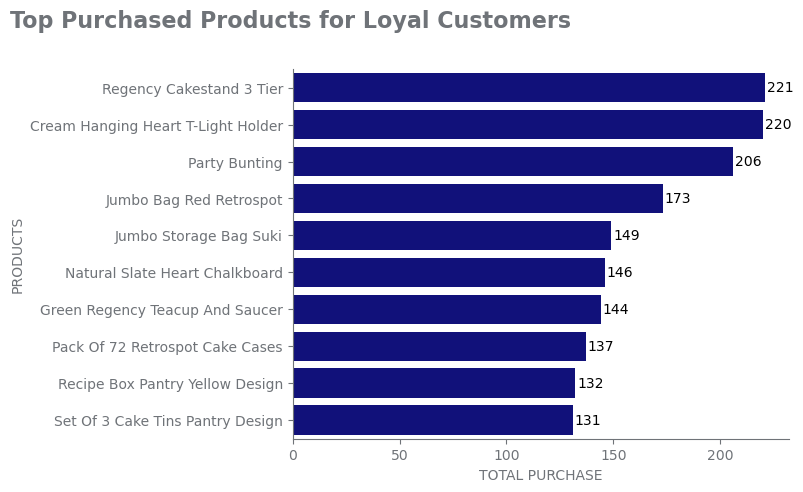

In [46]:
# Getting the top 10 favorite products for loyal customers
top_products = loyal_df['ProductName']\
               .value_counts()\
               .to_frame(name = 'Frequency')\
               .reset_index()\
               .iloc[:10]

# Setting the figure and axes
fig, ax = plt.subplots()

# Creating the bar plot
sns.barplot(x = 'Frequency', y = 'ProductName', data = top_products, color = 'darkblue', ax = ax)

# Removing top and right spines for both plots
sns.despine(right = True)

# Adding bar labels
ax.bar_label(ax.containers[0], padding = 1.5)

# Changing the tick color
ax.tick_params(color = '#6F7378') 

# Changing the x and y tick labels colors
plt.setp(ax.get_xticklabels(), color = '#6F7378') 
plt.setp(ax.get_yticklabels(), color = '#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('TOTAL PURCHASE', color = '#6F7378')
ax.set_ylabel('PRODUCTS', color = '#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')

# Setting title 
ax.set_title('Top Purchased Products for Loyal Customers', weight = 'bold', size = 16, 
             x = -0.57, pad = 30, ha = 'left', color = '#6F7378')

# Showing the plot
plt.show()

Unique values in Month column: ['January', 'February', 'March', 'April', 'May', ..., 'August', 'September', 'October', 'November', 'December']
Length: 12
Categories (12, object): ['January' < 'February' < 'March' < 'April' ... 'September' < 'October' < 'November' < 'December']


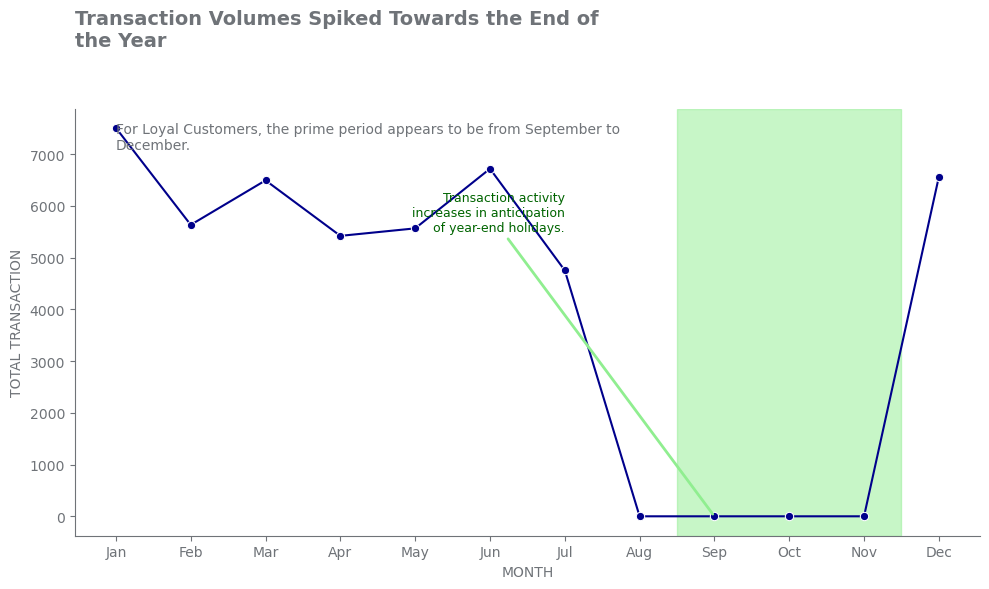

In [50]:
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

# Getting the total transaction frequency across month
monthly_trx = loyal_df['Month'].value_counts().to_frame().sort_index().reset_index()
monthly_trx.columns = ['Month', 'count']  # Ensure proper column names

# Debug: Check what's in the Month column
print("Unique values in Month column:", monthly_trx['Month'].unique())

# Create mapping for month conversion
month_map = {
    'jan': 1, 'january': 1, '1': 1, '01': 1,
    'feb': 2, 'february': 2, '2': 2, '02': 2,
    'mar': 3, 'march': 3, '3': 3, '03': 3,
    'apr': 4, 'april': 4, '4': 4, '04': 4,
    'may': 5, '5': 5, '05': 5,
    'jun': 6, 'june': 6, '6': 6, '06': 6,
    'jul': 7, 'july': 7, '7': 7, '07': 7,
    'aug': 8, 'august': 8, '8': 8, '08': 8,
    'sep': 9, 'september': 9, '9': 9, '09': 9,
    'oct': 10, 'october': 10, '10': 10,
    'nov': 11, 'november': 11, '11': 11,
    'dec': 12, 'december': 12, '12': 12
}

# Convert month to numeric (handles strings, numbers in string format, etc.)
monthly_trx['MonthNum'] = monthly_trx['Month'].astype(str).str.lower().map(month_map)

# Check for any null values in conversion
if monthly_trx['MonthNum'].isnull().any():
    print("Warning: Some month values couldn't be converted:")
    print(monthly_trx[monthly_trx['MonthNum'].isnull()]['Month'].unique())
    monthly_trx = monthly_trx.dropna(subset=['MonthNum'])

# Convert to proper month numbers
monthly_trx['MonthNum'] = monthly_trx['MonthNum'].astype(int)

# Get month abbreviations
monthly_trx['MonthAbb'] = monthly_trx['MonthNum'].apply(lambda x: calendar.month_abbr[x])

# Sort by month number to ensure proper order
monthly_trx = monthly_trx.sort_values('MonthNum')

# Setting the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Creating the line plot
sns.lineplot(x='MonthAbb', y='count', data=monthly_trx, 
             color='darkblue', ax=ax, marker='o', sort=False)

# Removing the top and right spines
sns.despine(right=True)

# Styling
ax.tick_params(color='#6F7378') 
plt.setp(ax.get_xticklabels(), color='#6F7378') 
plt.setp(ax.get_yticklabels(), color='#6F7378') 

# Setting the label names of both axes
ax.set_xlabel('MONTH', color='#6F7378')
ax.set_ylabel('TOTAL TRANSACTION', color='#6F7378')

# Changing the spines colors
for spine in ax.spines.values():
    spine.set_edgecolor('#6F7378')
    
# Adding rectangle background color to emphasize the 'peak' time
ax.axvspan(7.5, 10.5, color='lightgreen', alpha=.5)  # Adjusted indices for categorical x-axis

# Adding titles and annotations
ax.set_title('Transaction Volumes Spiked Towards the End of\nthe Year', size=14, weight='bold',
             pad=45, ha='left', x=0, color='#6F7378')
ax.text(0, ax.get_ylim()[1]*0.9,  # Dynamic y-position based on axis limits
        "For Loyal Customers, the prime period appears to be from September to\nDecember.",
        color='#6F7378')
ax.annotate('Transaction activity\nincreases in anticipation\nof year-end holidays.', 
            xy=(8, monthly_trx.loc[monthly_trx['MonthAbb'] == 'Sep', 'count'].values[0]), 
            xytext=(6, ax.get_ylim()[1]*0.7), 
            size=9, ha='right', color='darkgreen', 
            arrowprops={'arrowstyle': '-', 
                       'color': 'lightgreen', 
                       'linewidth': 2})

plt.tight_layout()
plt.show()